In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# I. Data Observations

In [248]:
# load data and drop useless columns
df = pd.read_csv("hotel_bookings.csv")
target = "is_canceled"
columns_to_drop = ["agent", "company", "reservation_status", "reservation_status_date"]
df = df.drop(columns=columns_to_drop)

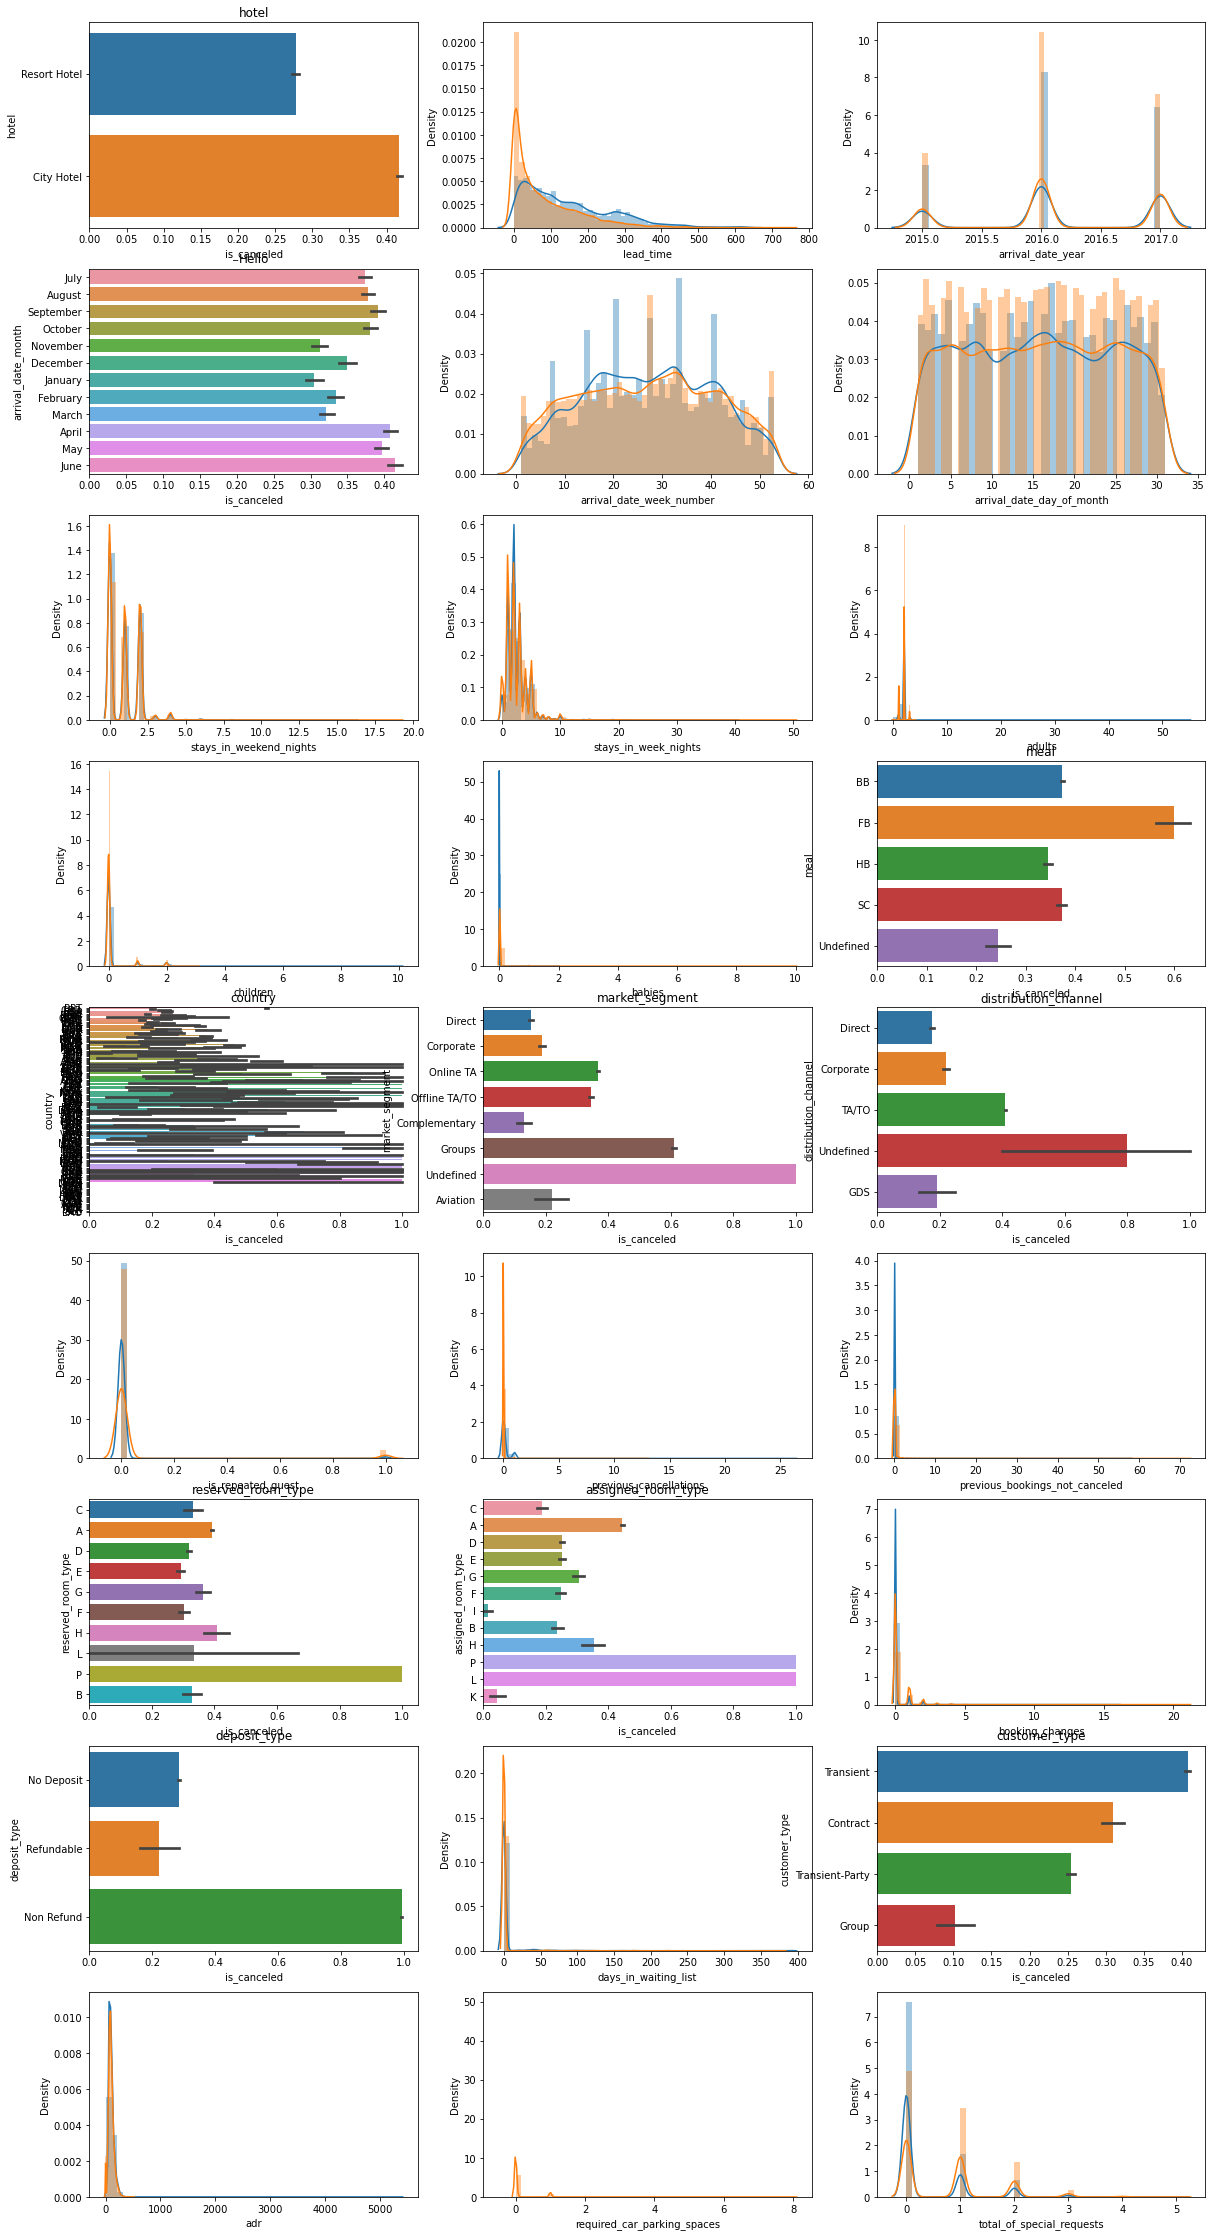

In [87]:
# compare distribution of canceled and non-canceled reservation
import warnings
warnings.filterwarnings('ignore')
idx = 0
fig, axes = plt.subplots(9, 3, figsize=(20, 40))
for col in df.columns:
    if col != target:
        if df.dtypes[col] == object:
            sns.barplot(x=target, y=col, data=df, ax=axes[idx // 3, idx % 3], );
            axes[idx // 3, idx % 3].set_title(col)
        else: 
            sns.distplot(df[df["is_canceled"] == 1][col], hist=True, label="Canceled", ax=axes[idx // 3, idx % 3]);
            sns.distplot(df[df["is_canceled"] == 0][col], hist=True, label="Not Cancel", ax=axes[idx // 3, idx % 3]);
            axes[1, 0].set_title("Hello")
        idx += 1

<AxesSubplot:xlabel='is_canceled', ylabel='index'>

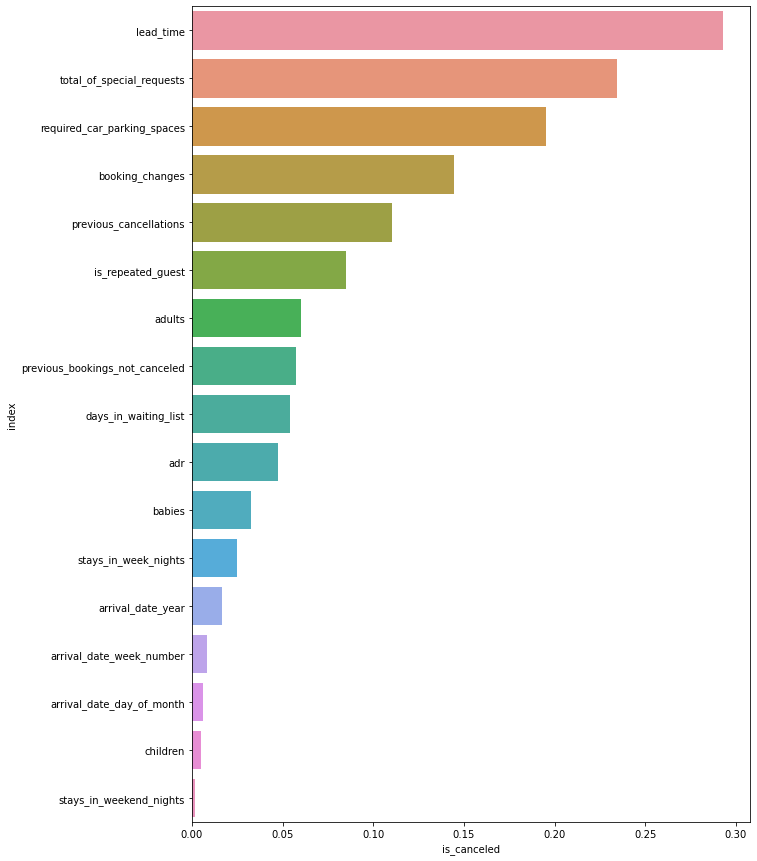

In [93]:
# correlation with Salesprice (first 20)
fig, ax = plt.subplots(figsize=(10, 15))

# computation of the correlation with target, will be used later 
correlations = df.corr()[target].reset_index()
correlations[target] = np.abs(correlations[target])
correlations = correlations.sort_values([target], ascending=False).reset_index(drop=True)
sns.barplot(ax=ax, y="index", x=target, data=correlations[1:40], orient="h")

**No feature is strongly correlated to the target**

## II. Feature Selection

In [345]:
import os
import WiSe 
import torch 
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import data_cleaning as dc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

In [346]:
# for the remainder of the notebook we will work with the reduce datasets 
df_train = pd.read_csv("hotel_bookings_train.csv")
df_test= pd.read_csv("hotel_bookings_test.csv")
target = "is_canceled"

In [347]:
def prepare_data(df):  
    unused_columns = ["agent", "company", "reservation_status", "reservation_status_date", "Unnamed: 0", "Set"] 
    df.drop(columns=unused_columns, inplace=True)

    # take care of non-value 
    df = df.dropna(how='any')
    df = df.reset_index(drop=True)
    
    # ordinal encoding 
    for non_numerical_feature_name in dc.non_numerical_features(df):
        dc.feature_ordinalEncoding(df, non_numerical_feature_name, inplace=True)
    return df

df_train = prepare_data(df_train)
df_test = prepare_data(df_test)

In [348]:
# apply univariate selection filters 
selected_pearson = WiSe.univariate_filter_spearman(df_train, target)
selected_spearman = WiSe.univariate_filter_spearman(df_train, target)
selected_univariate = list(set.union(set(selected_pearson), set(selected_spearman)))

In [349]:
# model selection based filtering 
selected_lasso = WiSe.model_selection_lasso(df_train, target, selected_univariate)
print("Remaining number of features: ", len(selected_lasso), "out of", df_train.shape[1] -1)

Remaining number of features:  12 out of 27


**Selection might have been brutal, so we produce a second set of selected features using RFE**

In [353]:
selected_rfe_20 = WiSe.model_selection_RFE(df_train, target, df_train.drop(columns=[target]).columns, 20)

In [354]:
selected_rfe_15 = WiSe.model_selection_RFE(df_train, target, df_train.drop(columns=[target]).columns, 15)

In [355]:
selected_rfe_15

Index(['arrival_date_year', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

In [318]:
# print the KPI
def print_kpi(y_pred, y_true):
    # print the AuROC
    print('AuROC: {:.2f}'.format(roc_auc_score(y_pred, y_true)))

    # print the percentage
    cm = confusion_matrix(y_pred, y_true)
    TP = cm[0,0]
    FP = cm[0,1]
    TN = cm[1,1]
    FN = cm[1,0]
    print("In ground truth dataset: {:.2f} % positive points".format(y_true[y_true == 1].shape[0]/y_true.shape[0]*100))
    print("In ground truth dataset: {:.2f} % negative points".format(y_true[y_true == 0].shape[0]/y_true.shape[0]*100))

    print("Out of positive prediction: {:.2f} % were correct".format(TP/(TP+FP)*100))
    print("Out of positive prediction: {:.2f} % were incorrect".format(FP/(TP+FP)*100))
    print("Out of negative prediction: {:.2f} % were correct".format(TN/(TN+FN)*100))
    print("Out of negative prediction: {:.2f} % were incorrect".format(FN/(TN+FN)*100))

## III. Predictions using XGBoost

In [13]:
training_data, testing_data = train_test_split(df_train, test_size=0.2, random_state=4)

C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


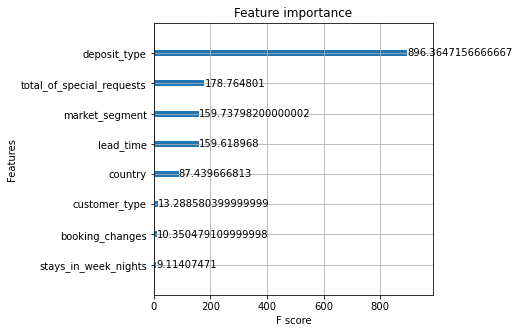

AuROC: 0.83
In ground truth dataset: 36.76 % positive points
In ground truth dataset: 63.24 % negative points
Out of positive prediction: 73.46 % were correct
Out of positive prediction: 26.54 % were incorrect
Out of negative prediction: 91.97 % were correct
Out of negative prediction: 8.03 % were incorrect


In [325]:
# XGBoost model on the entire dataset
X_train, y_train = training_data.drop(columns=target), training_data[target]
X_test, y_test = testing_data.drop(columns=target), testing_data[target]

clf_xgb = xgb.XGBClassifier(max_depth=3,
    learning_rate=0.01,
    n_estimators=6,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,
    use_label_encoder=False)

clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)
xgb.plot_importance(clf_xgb, importance_type='gain', max_num_features=8)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()
print_kpi(y_pred, y_test)

C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


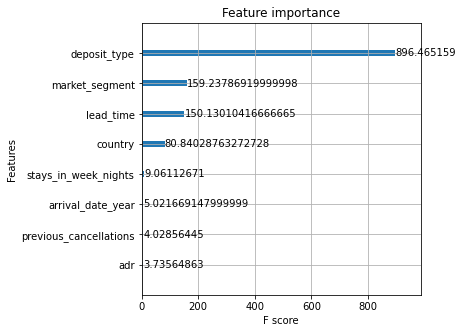

AuROC: 0.86
In ground truth dataset: 36.76 % positive points
In ground truth dataset: 63.24 % negative points
Out of positive prediction: 71.85 % were correct
Out of positive prediction: 28.15 % were incorrect
Out of negative prediction: 100.00 % were correct
Out of negative prediction: 0.00 % were incorrect


In [326]:
# XGBoost model on a selected number of features 
X_train, y_train = training_data[selected_lasso], training_data[target]
X_test, y_test = testing_data[selected_lasso], testing_data[target]

clf_xgb = xgb.XGBClassifier(max_depth=3,
    learning_rate=0.01,
    n_estimators=6,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,
    use_label_encoder=False)

clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)
xgb.plot_importance(clf_xgb, importance_type='gain', max_num_features=8)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()
print_kpi(y_pred, y_test)

**Need to code a custom loss for training that takes into account the weight difference**

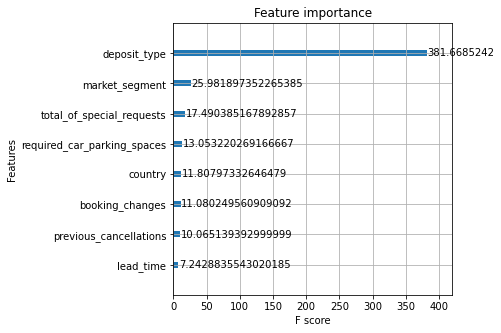

AuROC: 0.80
In ground truth dataset: 36.76 % positive points
In ground truth dataset: 63.24 % negative points
Out of positive prediction: 86.60 % were correct
Out of positive prediction: 13.40 % were incorrect
Out of negative prediction: 73.08 % were correct
Out of negative prediction: 26.92 % were incorrect


C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [327]:
# XGBoost model taking into account class balance & trainined on the entire dataset
X_train, y_train = training_data.drop(columns=target), training_data[target]
X_test, y_test = testing_data.drop(columns=target), testing_data[target]

# place weights on datapoint 
postive_weight = len(y_train[y_train == 1])/len(y_train)
negative_weight = len(y_train[y_train == 0])/len(y_train)
sample_weights_data = y_train*negative_weight + np.abs(y_train-1)*postive_weight

# define and train the model 
clf_xgb = xgb.XGBClassifier(max_depth=23,
    learning_rate=0.01,
    n_estimators=5,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,
    use_label_encoder=False)

clf_xgb.fit(X_train, y_train, sample_weight=sample_weights_data)

# plot results about the model 
xgb.plot_importance(clf_xgb, importance_type='gain', max_num_features=8)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()
y_pred = clf_xgb.predict(X_test)
print_kpi(y_pred, y_test)

**The last weighted model is able to increase the number of positive prediction, howerver, this is done at the expanse of negative**  
overall, the model trained using XGBoost might be a little bit too simple, lets train a Neural Network. 

## IV. Predictions using TabNet

In [332]:
def train_tabnet(features, lr=0.5, max_epochs=100, lambda_sparse=1e-5, n_steps=7, weights=0, verbose=1): 
    df = pd.read_csv("hotel_bookings_train.csv")
    target = "is_canceled"
    columns_to_drop = ["agent", "company", "reservation_status", "reservation_status_date", "Unnamed: 0"]
    df = df.drop(columns=columns_to_drop)    
    df = df.dropna().reset_index(drop=True)
    
    df["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(df.shape[0],))

    train_indices = df[df.Set=="train"].index
    valid_indices = df[df.Set=="valid"].index
    
    if features.any() == None:
        features=df.drop(columns=[target, "Set"]).columns
    
    # detect dimensions columns and encode them
    nunique = df.nunique()
    types = df.dtypes
    categorical_columns = []
    categorical_dims =  {}
    for col in df.columns:
        if types[col] == 'object':
            l_enc = LabelEncoder()
            df[col] = l_enc.fit_transform(df[col].values)
            categorical_columns.append(col)
            categorical_dims[col] = len(l_enc.classes_)
        else:
            df.fillna(df.loc[train_indices, col].mean(), inplace=True)
    
    # create the dimensions for training 
    cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
    cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
    
    # get the training, validation and testing data
    X_train = df[features].values[train_indices]
    y_train = df[target].values[train_indices]
    X_valid = df[features].values[valid_indices]
    y_valid = df[target].values[valid_indices]

    # configure the model
    clf = TabNetClassifier(
                       n_d=15, n_a=15,
                       cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=lr),
                       lambda_sparse=lambda_sparse,
                       n_steps=7,
                       scheduler_params={"step_size":75, # how to use learning rate scheduler
                                         "gamma":0.7},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax',
                       verbose=verbose,
                      )
    
    # train the model
    max_epochs_ = max_epochs if not os.getenv("CI", False) else 2
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs,
        patience=50,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        drop_last=False, 
        weights=weights
    )
    
    print("Best AuROC on validation: {:.2f}".format(clf.best_cost))
    return clf, X_train, y_train, X_valid, y_valid, features 

In [320]:
def print_feature_importance(tabnet_model, features, nbr_features_to_print=10):
    dict_feature_importance = dict(zip(features, tabnet_model.feature_importances_))
    dict_feature_importance = {k: v for k, v in sorted(dict_feature_importance.items(), key=lambda item: item[1], reverse=True)}

    fig, ax = plt.subplots()

    y_pos = np.arange(len(features))

    ax.barh(y_pos[:nbr_features_to_print], list(dict_feature_importance.values())[:nbr_features_to_print], align='center')
    ax.set_yticks(y_pos[:nbr_features_to_print])
    ax.set_yticklabels(list(dict_feature_importance.keys())[:nbr_features_to_print])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Relative Importance in the Descision')
    ax.set_title('Feature Importance')
    plt.show()

Stop training because you reached max_epochs = 150 with best_epoch = 147 and best_valid_auc = 0.92295
Best weights from best epoch are automatically used!
Best AuROC on validation: 0.92


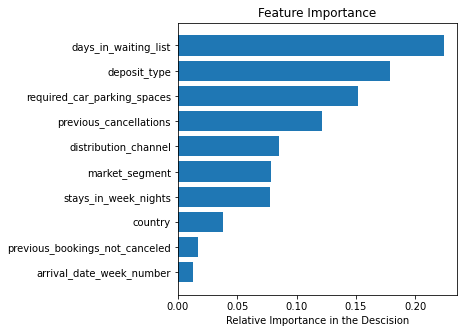

AuROC: 0.83
In ground truth dataset: 40.68 % positive points
In ground truth dataset: 59.32 % negative points
Out of positive prediction: 84.14 % were correct
Out of positive prediction: 15.86 % were incorrect
Out of negative prediction: 81.19 % were correct
Out of negative prediction: 18.81 % were incorrect


In [329]:
# basic model: all features, no class weights taken into account
clf_basic, _, _, X_valid_basic, y_valid_basic, features_basic = train_tabnet(features=None, 
                                                                             lr=0.1, max_epochs=150, lambda_sparse=1e-5, 
                                                                             n_steps=7, weights=0, verbose=0)
print_feature_importance(clf_basic, features_basic, 10)
y_pred = clf_basic.predict(X_valid_basic)
print_kpi(y_pred, y_valid_basic)

Stop training because you reached max_epochs = 100 with best_epoch = 95 and best_valid_auc = 0.88532
Best weights from best epoch are automatically used!
Best AuROC on validation: 0.89


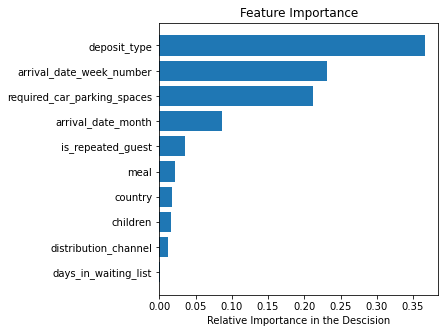

AuROC: 0.82
In ground truth dataset: 39.44 % positive points
In ground truth dataset: 60.56 % negative points
Out of positive prediction: 77.47 % were correct
Out of positive prediction: 22.53 % were incorrect
Out of negative prediction: 85.58 % were correct
Out of negative prediction: 14.42 % were incorrect


In [330]:
# taking care of the balancing 
clf_balance, _, _, X_valid_balance, y_valid_balance, features_balance = train_tabnet(features=None, 
                                                                             lr=0.1, max_epochs=100, lambda_sparse=1e-5, 
                                                                             n_steps=7, weights=1, verbose=0)
print_feature_importance(clf_balance, features_balance, 10)
y_pred_balance = clf_balance.predict(X_valid_balance)
print_kpi(y_pred_balance, y_valid_balance)

Stop training because you reached max_epochs = 100 with best_epoch = 83 and best_valid_auc = 0.87259
Best weights from best epoch are automatically used!
Best AuROC on validation: 0.87


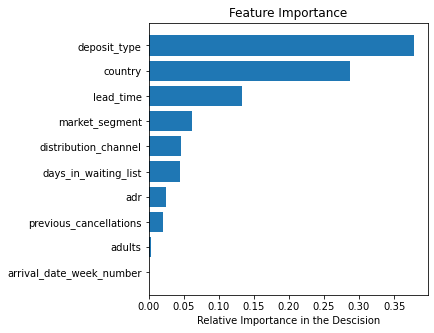

AuROC: 0.79
In ground truth dataset: 39.14 % positive points
In ground truth dataset: 60.86 % negative points
Out of positive prediction: 76.92 % were correct
Out of positive prediction: 23.08 % were incorrect
Out of negative prediction: 80.49 % were correct
Out of negative prediction: 19.51 % were incorrect


In [333]:
# only keep features from WiSe selection & discard unballanced dataset 
clf_WiSe, _, _, X_valid_WiSe, y_valid_WiSe, featurses_WiSe = train_tabnet(features=selected_lasso, 
                                                                             lr=0.1, max_epochs=100, lambda_sparse=1e-5, 
                                                                             n_steps=7, weights=0, verbose=0)
print_feature_importance(clf_WiSe, featurses_WiSe, 10)
y_pred_WiSe = clf_WiSe.predict(X_valid_WiSe)
print_kpi(y_pred_WiSe, y_valid_WiSe)

Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_valid_auc = 0.85648
Best weights from best epoch are automatically used!
Best AuROC on validation: 0.86


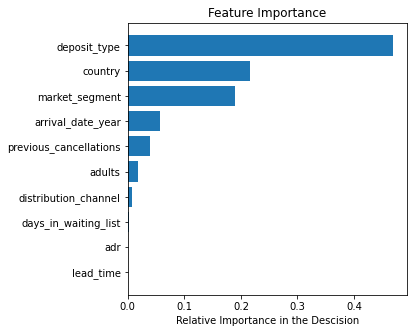

AuROC: 0.75
In ground truth dataset: 37.15 % positive points
In ground truth dataset: 62.85 % negative points
Out of positive prediction: 88.09 % were correct
Out of positive prediction: 11.91 % were incorrect
Out of negative prediction: 61.48 % were correct
Out of negative prediction: 38.52 % were incorrect


In [359]:
# only keep features from WiSe selection & discard unballanced dataset 
clf_WiSe_balance, _, _, X_valid_WiSe_balance, y_valid_WiSe_balance, featurses_WiSe_balance = train_tabnet(features=selected_lasso, 
                                                                             lr=0.1, max_epochs=150, lambda_sparse=1e-5, 
                                                                             n_steps=7, weights=1, verbose=0)
print_feature_importance(clf_WiSe_balance, featurses_WiSe_balance, 10)
y_pred_WiSe_balance = clf_WiSe_balance.predict(X_valid_WiSe_balance)
print_kpi(y_pred_WiSe_balance, y_valid_WiSe_balance)

Stop training because you reached max_epochs = 150 with best_epoch = 133 and best_valid_auc = 0.84009
Best weights from best epoch are automatically used!
Best AuROC on validation: 0.84


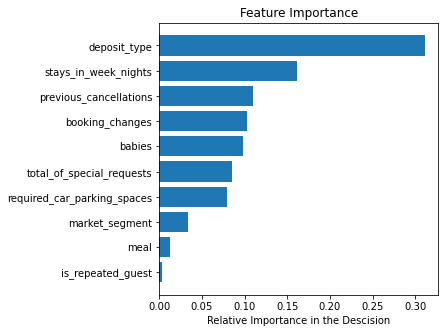

AuROC: 0.79
In ground truth dataset: 38.06 % positive points
In ground truth dataset: 61.94 % negative points
Out of positive prediction: 79.14 % were correct
Out of positive prediction: 20.86 % were incorrect
Out of negative prediction: 77.87 % were correct
Out of negative prediction: 22.13 % were incorrect


In [360]:
# only keep features from WiSe selection & discard unballanced dataset 
clf_RFE_15, _, _, X_valid_RFE_15, y_valid_RFE_15, features_RFE_15 = train_tabnet(features=selected_rfe_15, 
                                                                             lr=0.1, max_epochs=150, lambda_sparse=1e-5, 
                                                                             n_steps=7, weights=0, verbose=0)
print_feature_importance(clf_RFE_15, features_RFE_15, 10)
y_pred_RFE_15 = clf_RFE_15.predict(X_valid_RFE_15)
print_kpi(y_pred_RFE_15, y_valid_RFE_15)


Early stopping occurred at epoch 60 with best_epoch = 10 and best_valid_auc = 0.76419
Best weights from best epoch are automatically used!
Best AuROC on validation: 0.76


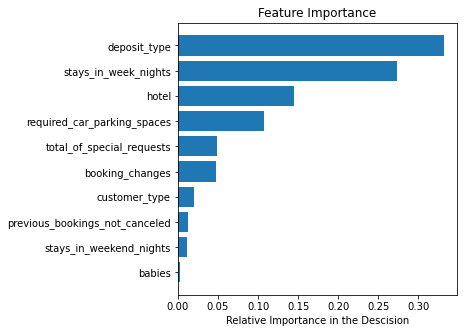

AuROC: 0.86
In ground truth dataset: 36.74 % positive points
In ground truth dataset: 63.26 % negative points
Out of positive prediction: 71.96 % were correct
Out of positive prediction: 28.04 % were incorrect
Out of negative prediction: 99.50 % were correct
Out of negative prediction: 0.50 % were incorrect


In [358]:
# only keep features from WiSe selection & discard unballanced dataset 
clf_RFE_20, _, _, X_valid_RFE_20, y_valid_RFE_20, features_RFE_20 = train_tabnet(features=selected_rfe_20, 
                                                                             lr=0.1, max_epochs=150, lambda_sparse=1e-5, 
                                                                             n_steps=7, weights=0, verbose=0)
print_feature_importance(clf_RFE_20, features_RFE_20, 10)
y_pred_RFE_20 = clf_RFE_20.predict(X_valid_RFE_20)
print_kpi(y_pred_RFE_20, y_valid_RFE_20)

Stop training because you reached max_epochs = 150 with best_epoch = 137 and best_valid_auc = 0.86466
Best weights from best epoch are automatically used!
Best AuROC on validation: 0.86


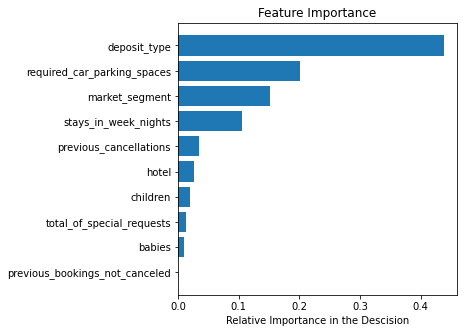

AuROC: 0.79
In ground truth dataset: 37.61 % positive points
In ground truth dataset: 62.39 % negative points
Out of positive prediction: 83.08 % were correct
Out of positive prediction: 16.92 % were incorrect
Out of negative prediction: 74.01 % were correct
Out of negative prediction: 25.99 % were incorrect


In [362]:
# only keep features from WiSe selection & discard unballanced dataset 
clf_RFE_20_balance, _, _, X_valid_RFE_20_balance, y_valid_RFE_20_balance, features_RFE_20_balance = train_tabnet(features=selected_rfe_20, 
                                                                             lr=0.1, max_epochs=150, lambda_sparse=1e-5, 
                                                                             n_steps=7, weights=1, verbose=0)
print_feature_importance(clf_RFE_20_balance, features_RFE_20_balance, 10)
y_pred_RFE_20_balance = clf_RFE_20_balance.predict(X_valid_RFE_20_balance)
print_kpi(y_pred_RFE_20_balance, y_valid_RFE_20_balance)